# Pong Analysis

Analysing the results of the initial Pong simulations.

## Setup

In [1]:
import pickle
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import gym
from atariari.benchmark.wrapper import AtariARIWrapper
import neat

from custom_neat.nn.recurrent import RNN
from custom_neat.genome import Genome

In [2]:
BASE_DIR = '../experiments/pong/pong_results/'

## Experiment Configuration

A copy of the experiment configuration used.

## Load Results

In [3]:
def load_genome(path):
    """Load a pickled genome.
    
    Args:
        path (str): The path to the pickled genome object.
    
    Returns:
        Genome: The genome.
    """
    return pickle.load(open(path, 'rb'))

## Measuring Learning

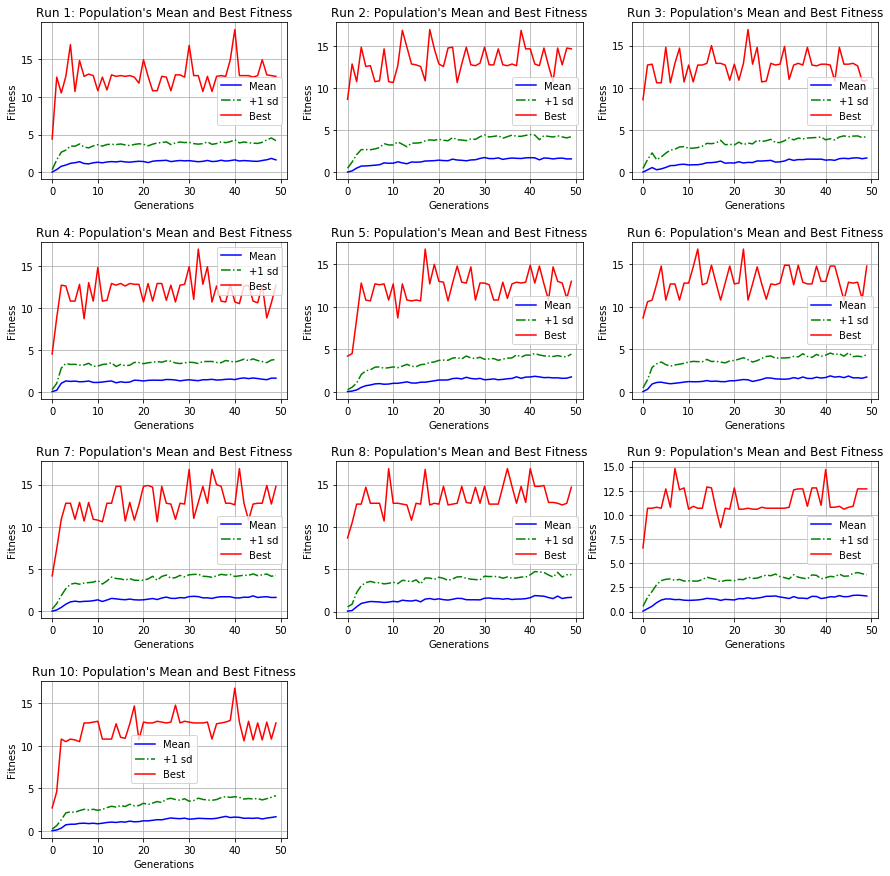

In [4]:
# Plot best and average fitness over time for each run
n_subplots = 10
cols = 3
rows = n_subplots // cols + n_subplots % cols
plt_position = range(1, n_subplots + 1)
fig = plt.figure(1, figsize=(15, 15))

for k in range(n_subplots):
    # Load statistics reporter
    stats = pickle.load(open(BASE_DIR + f'run_{k + 1}/stats_reporter.pickle', 'rb'))

    # Gather statistics
    generation = range(len(stats.most_fit_genomes))
    best_fitness = [c.fitness for c in stats.most_fit_genomes]
    avg_fitness = np.array(stats.get_fitness_mean())
    stdev_fitness = np.array(stats.get_fitness_stdev())
    
    # Plot
    ax = fig.add_subplot(rows, cols, plt_position[k])

    plt.plot(generation, avg_fitness, 'b-', label='Mean')
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label='+1 sd')
    plt.plot(generation, best_fitness, 'r-', label='Best')

    plt.title(f"Run {k + 1}: Population's Mean and Best Fitness")
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plt.grid()
    plt.legend(loc='best')

plt.subplots_adjust(hspace=0.4)
plt.show()

**Notes**

* In each run, the fitness tends to plateau early. Increases in fitness do not appear to lead the population towards more fit solutions.
* I wouldn't necessarily expect fitness to increase steadily over time, but I would expect the mean fitness to approach the best fitness.


* Possible causes for the observed behaviour:
    * The mutation operators are too aggressive, producing low performing children even when the parent(s) are high performing.
    * Too many low performing solutions are being carried over or being used as parents for the next generation, resulting in a new population that are the offspring of primarily low performing solutions.
    * The measure of fitness (average score obtained over 10 episodes) is not representative of the true quality of the solution. I think this is unlikely as an agent is unlikely to 'get lucky' in 10 consecutive episodes. However, due to elitism the best fitness should never significantly decrease *if* the measure of fitness is representative.

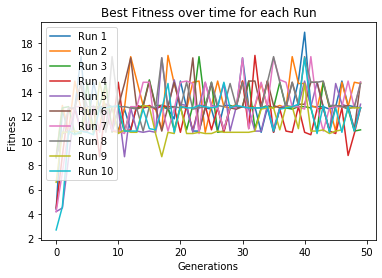

In [5]:
# Compare best fitness over time between runs
for run in range(1, 11):
    # Load statistics reporter
    stats = pickle.load(open(BASE_DIR + f'run_{run}/stats_reporter.pickle', 'rb'))

    # Gather statistics
    generation = range(len(stats.most_fit_genomes))
    best_fitness = [c.fitness for c in stats.most_fit_genomes]
    avg_fitness = np.array(stats.get_fitness_mean())
    stdev_fitness = np.array(stats.get_fitness_stdev())
    
    # Plot
    plt.plot(generation, best_fitness, label=f'Run {run}')

    plt.title(f'Best Fitness over time for each Run')
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plt.grid()
    plt.legend(loc='best')

plt.show()

**Notes**

* Overlaying the best fitness trend for each run shows consistent (if poor) results over all runs. This indicates robustness against differing initial conditions.
* The 'spiking' nature of best solutions suggests that the measure of fitness is not representative of the true quality of the solutions. If it is representative then the best fitness should not reduce because elitism dictates the the best performing individuals are copied over unaltered.


**To Do**

* Assess the variability in the scores of the 'best' genomes and answer the question of how many episodes are required to get an accurate estimate of the true performance of a genome.

## How Many Episodes are Required to get a Good Estimate of Fitness?

In [6]:
def evaluate_genome(genome, n_episodes=10):
    """Evaluate a genome.
    
    Genomes are evaluated by averaging their reward over a
    number of episodes.
    
    Args:
        genome (Genome): The genome to evaluate.
        n_episodes (int): The number of episodes over which
            to evaluate the agent.
    Returns:
        float: The mean fitness over all episodes.
        float: The standard deviation of the fitnesses over
            all episodes.
    """
    network = RNN.create(genome)
    env = AtariARIWrapper(gym.make('Pong-v4'))
    output_to_action = {
        0: 0,  # NOOP
        1: 2,  # RIGHT (UP)
        2: 3   # LEFT  (DOWN)
    }
    
    episode_fitnesses = []
    for i in range(n_episodes):
        img = env.reset()
        img, reward, done, state = env.step(2)  # TODO: Change 2 (UP) -> 0 (NOOP)
        network.reset()

        while not done:
            obs = [state['labels']['player_y'],
                   state['labels']['enemy_y'],
                   state['labels']['ball_x'],
                   state['labels']['ball_y']]

            output = network.forward(obs)
            action = output_to_action[np.argmax(output)]

            img, reward, done, state = env.step(action)

        episode_fitnesses.append(state['labels']['player_score'])

    env.close()
    return np.mean(episode_fitnesses), np.std(episode_fitnesses)

In [7]:
# Load best genomes for each generation in Run 1
solutions = []

for filename in os.listdir(BASE_DIR + 'run_1/'):
    if filename.startswith("solution_"):
        _, generation = filename.strip('.pickle').split('_')
        genome = pickle.load(open(BASE_DIR + 'run_1/' + filename, 'rb'))
        solutions.append((int(generation), genome))

solutions.sort(key=lambda x: x[0])

In [10]:
# Compute the mean and std. dev. of genome fitness over 10 runs
replicated_means = []
replicated_sds = []
for generation, genome in solutions[:10]:
    mean_fitness, sd_fitness = evaluate_genome(genome, n_episodes=10)
    replicated_means.append(mean_fitness)
    replicated_sds.append(sd_fitness)
    
    template = 'Generation {}: Original = {}, Replicated = (mu: {:.2f}, sd: {:.2f})'
    print(template.format(generation, genome.fitness, mean_fitness, sd_fitness))

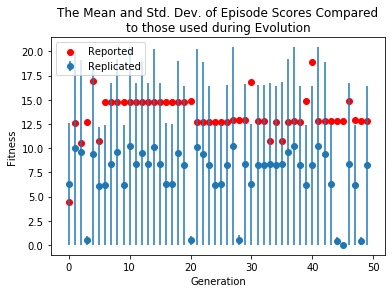

In [34]:
# Plot the original and replicated fitness statistics
generations, genomes = zip(*solutions)
plt.errorbar(generations, replicated_sds, replicated_sds,
             fmt='o', label='Replicated')
plt.scatter(generations, [g.fitness for g in genomes],
            label='Reported', c='r')
plt.legend(loc='best')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('The Mean and Std. Dev. of Episode Scores Compared\nto those used during Evolution')
plt.show()

**Notes**

* The variability in episode scores over 10 episodes is very high. Fitness should be evaluated over a greated number of episodes.
* Variability appears to remain constant as evolution proceeds.

In [42]:
best = pickle.load(open(BASE_DIR + 'run_1/' + 'solution.pickle', 'rb'))
means = []
for i in range(100):
    means.append(evaluate_genome(best, n_episodes=10)[0])

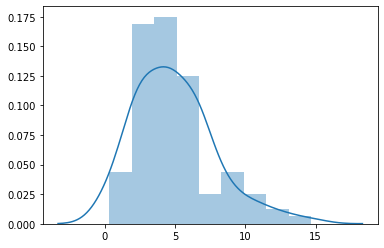

In [43]:
sns.distplot(means)
plt.show()

In [46]:
np.std(means)

2.8620055904906962

In [44]:
best = pickle.load(open(BASE_DIR + 'run_1/' + 'solution.pickle', 'rb'))
means_20 = []
for i in range(100):
    means_20.append(evaluate_genome(best, n_episodes=20)[0])

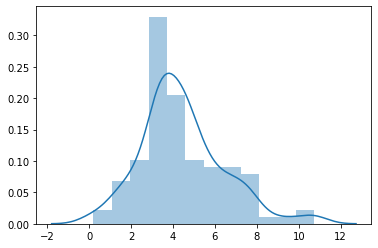

In [45]:
sns.distplot(means_20)
plt.show()

In [47]:
np.std(means_20)

1.9935430770364606

In [37]:
# How much does increasing the number of episodes to 20 reduce the variability?
replicated_means_20 = []
replicated_sds_20 = []
for generation, genome in solutions[:10]:
    mean_fitness, sd_fitness = evaluate_genome(genome, n_episodes=20)
    replicated_means_20.append(mean_fitness)
    replicated_sds_20.append(sd_fitness)
    
    template = 'Generation {}: Original = {}, Replicated = (mu: {:.2f}, sd: {:.2f})'
    print(template.format(generation, genome.fitness, mean_fitness, sd_fitness))

Generation 0: Original = 4.4, Replicated = (mu: 1.40, sd: 4.52)
Generation 1: Original = 12.6, Replicated = (mu: 5.40, sd: 9.01)
Generation 2: Original = 10.5, Replicated = (mu: 8.55, sd: 10.17)
Generation 3: Original = 12.7, Replicated = (mu: 3.40, sd: 7.41)
Generation 4: Original = 16.9, Replicated = (mu: 2.25, sd: 6.26)
Generation 5: Original = 10.7, Replicated = (mu: 4.55, sd: 8.24)
Generation 6: Original = 14.8, Replicated = (mu: 4.30, sd: 8.36)
Generation 7: Original = 14.8, Replicated = (mu: 7.55, sd: 9.88)
Generation 8: Original = 14.8, Replicated = (mu: 5.50, sd: 8.96)
Generation 9: Original = 14.8, Replicated = (mu: 6.40, sd: 9.56)


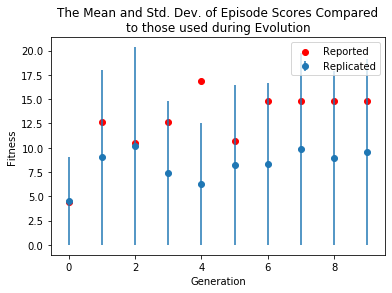

In [38]:
# Plot the original and replicated fitness statistics
generations, genomes = zip(*solutions[:10])
plt.errorbar(generations, replicated_sds_20, replicated_sds_20,
             fmt='o', label='Replicated')
plt.scatter(generations, [g.fitness for g in genomes],
            label='Reported', c='r')
plt.legend(loc='best')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('The Mean and Std. Dev. of Episode Scores Compared\nto those used during Evolution')
plt.show()

## Distribution of Fitness Over Time

In [6]:
# Load population checkpoints
populations = []
for filename in os.listdir(BASE_DIR + 'run_1/checkpoints/'):
    population = neat.Checkpointer.restore_checkpoint(BASE_DIR + 'run_1/checkpoints/' + filename)
    populations.append(population)
    
populations.sort(key=lambda x: x.generation)

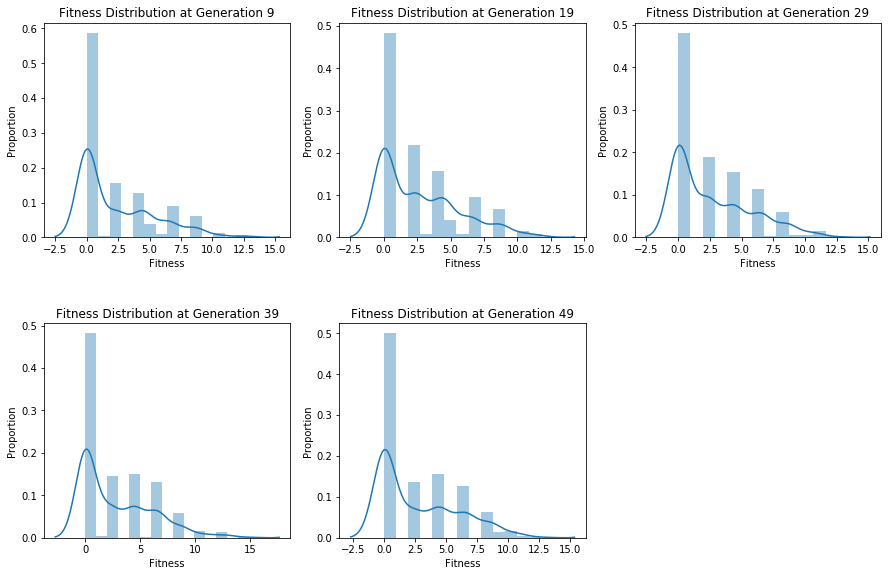

In [10]:
# Plot fitness distribution over time
n_subplots = 5
cols = 3
rows = n_subplots // cols + n_subplots % cols
plt_position = range(1, n_subplots + 1)
fig = plt.figure(1, figsize=(15, 15))

for k in range(n_subplots):
    # Get population
    population = populations[k]
    
    # Get fitness for all genomes in the population
    fitnesses = [g.fitness for g in population.population.values() if g.fitness is not None]    
    
    # Plot
    ax = fig.add_subplot(rows, cols, plt_position[k])

    sns.distplot(fitnesses)

    plt.title(f'Fitness Distribution at Generation {population.generation}')
    plt.xlabel('Fitness')
    plt.ylabel('Proportion')

plt.subplots_adjust(hspace=0.4)
plt.show()

**Notes**

* The fitness distribution remains stagnant over time. Ideally, the distribution would gradually shift to the right as the population improves.

## Distribution of Fitness Over Time per Species